# Importing Libraries 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# Extract Data

In [2]:
from zipfile import ZipFile
data_path = 'lung_colon_image_set\lung_image_sets.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


# Data Visualization
In this section, we will try to understand visualize some images which have been provided to us to build the classifier for each class.

In [3]:
path = 'lung_colon_image_set\lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

# Three images from each class of the three classes

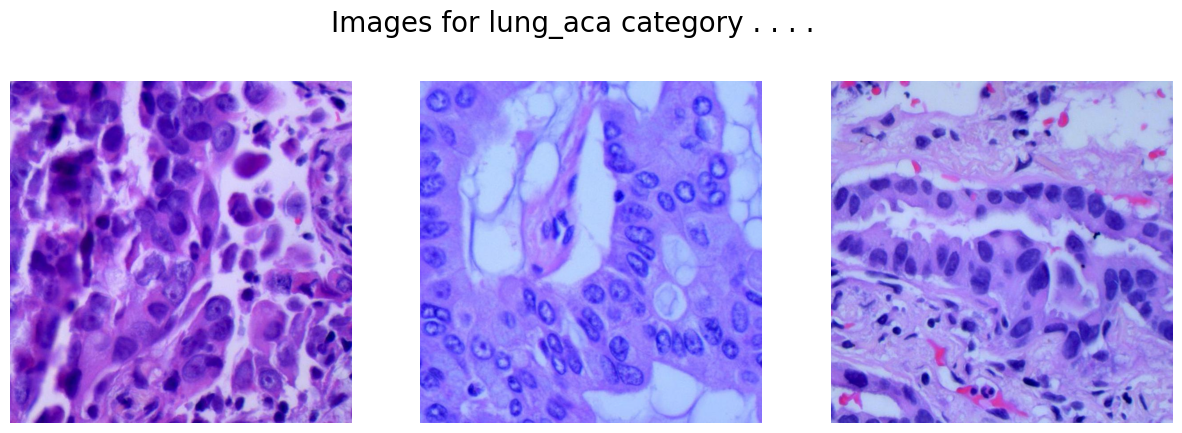

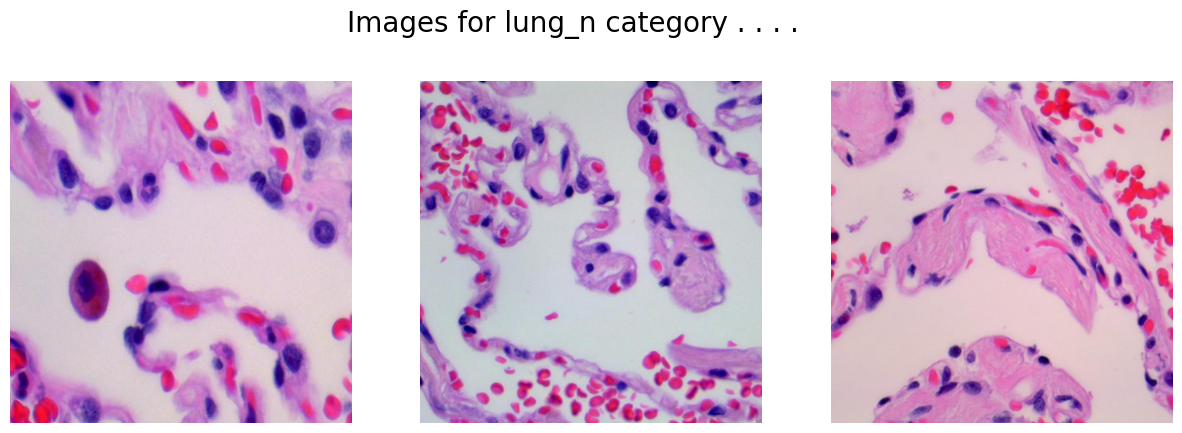

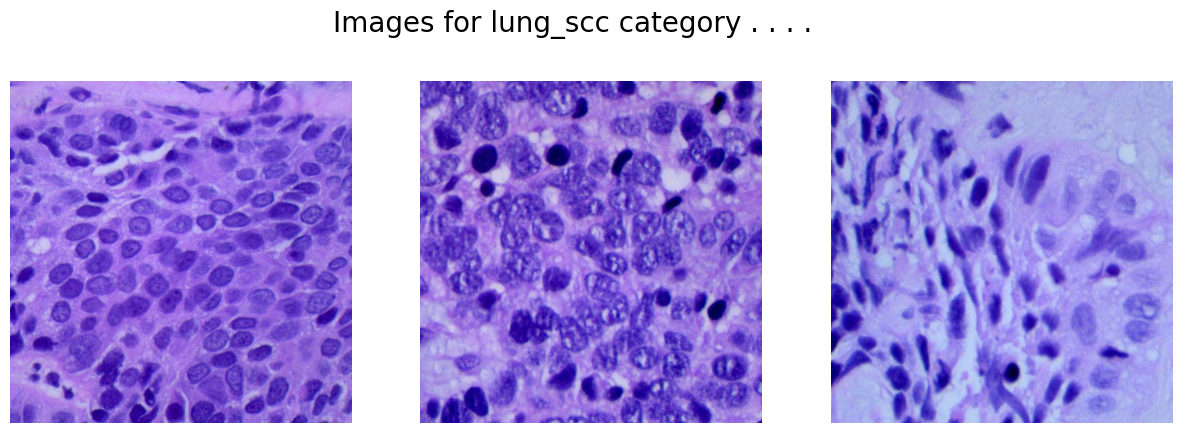

In [4]:
path = 'lung_colon_image_set\lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.suptitle(f'Images for {cat} category . . . .',
				fontsize = 20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


# Data Preparation for Training

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

# convert the given images into NumPy arrays of their pixels after resizing them because training

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
	    img = cv2.imread(image)
	
	    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

print("Done...")


Done...


# One hot encoding

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)
print("Done...")


(12000, 256, 256, 3) (3000, 256, 256, 3)
Done...


# Model Development 

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)

print("Done...")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 504s 6us/step
Done...


# how deep this model Number of layers in the pre-train

In [11]:
len(pre_trained_model.layers)


311

# The parameters of a model we import are already trained, we do not need to train them again.

In [16]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [19]:
last_layer = pre_trained_model.get_layer('mixed7')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


In [20]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)


# compiling a model

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90%\
            so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience = 3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
					patience = 2,
					factor = 0.5,
					verbose = 1)
print("Done...")

Done...


# Now we will train our model:

In [23]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.7942 - loss: 0.5157 - val_accuracy: 0.7943 - val_loss: 0.5079 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.9060 - loss: 0.2264 - val_accuracy: 0.8297 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9331 - loss: 0.1772
 Validation accuracy has reached upto 90%            so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9331 - loss: 0.1772 - val_accuracy: 0.9237 - val_loss: 0.1972 - learning_rate: 0.0010


# Let’s visualize the training and validation accuracy with each epoch.

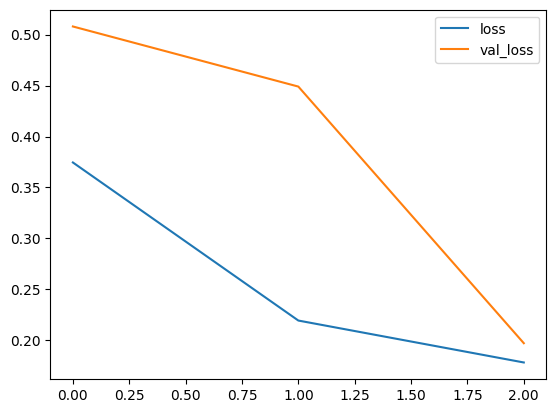

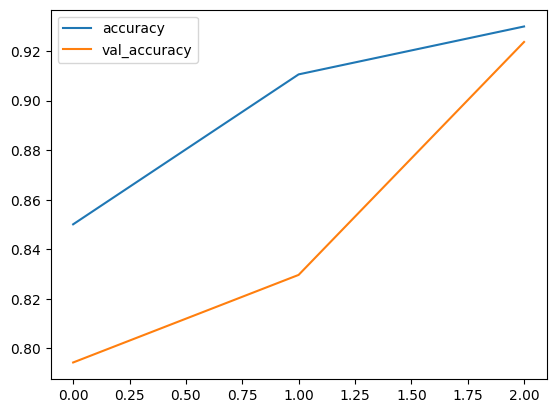

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


# Model Evaluation

In [25]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 728ms/step


# Let’s draw the confusion metrics and classification report using the predicted labels and the true labels.

In [26]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[860,  71,  56],
       [  6, 971,   0],
       [ 88,   8, 940]], dtype=int64)

In [27]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.90      0.87      0.89       987
      lung_n       0.92      0.99      0.96       977
    lung_scc       0.94      0.91      0.93      1036

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [28]:
model.save('lung_cancer_model.h5')
